# Store sales - Time series

https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Preprocessing

In [27]:
df = pd.read_csv('data/train.csv')

In [28]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [30]:
df.date = pd.to_datetime(df.date)

In [31]:
df.set_index(['date'], inplace=True)

In [32]:
df = df.drop(columns=['id'])

In [33]:
y = df['sales']
X = df.drop(columns=['sales'])
X.head()

,store_nbr,family,onpromotion
date,,,
2013-01-01,1,AUTOMOTIVE,0
2013-01-01,1,BABY CARE,0
2013-01-01,1,BEAUTY,0
2013-01-01,1,BEVERAGES,0
2013-01-01,1,BOOKS,0


In [34]:
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*df.shape[0])

df_train = df.iloc[:index]
df_val = df.iloc[index:]

## Baseline

In [35]:
y_pred = df_val.shift(1)
y_pred

,store_nbr,family,sales,onpromotion
date,,,,
2015-10-10,NaN,NaN,NaN,NaN
2015-10-10,29.0,LAWN AND GARDEN,0.000,0.0
2015-10-10,29.0,LINGERIE,3.000,0.0
2015-10-10,29.0,"LIQUOR,WINE,BEER",276.000,0.0
2015-10-10,29.0,MAGAZINES,3.000,0.0
...,...,...,...,...
2017-08-15,9.0,PLAYERS AND ELECTRONICS,6.000,0.0
2017-08-15,9.0,POULTRY,438.133,0.0
2017-08-15,9.0,PREPARED FOODS,154.553,1.0


In [40]:
from sklearn.metrics import r2_score

y_pred = df_val.shift(1).dropna()['sales']
y_true = df_val[1:]['sales']

print(f"R2: {r2_score(y_true, y_pred)}")

R2: -1.0926475580943995


## Linear model with 12 autoregressive features

In [45]:
df2 = df.copy().drop(columns=['family'])
df2_train = df_train.copy().drop(columns=['family'])
df2_val = df_val.copy().drop(columns=['family'])

for i in range(1,13):
    df2_train[f't - {i}'] = df_train['sales'].shift(i)
    df2_val[f't - {i}'] = df_val['sales'].shift(i)

df2_train.dropna(inplace=True)
df2_val.dropna(inplace=True)

df2_train.head()

,store_nbr,sales,onpromotion,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
date,,,,,,,,,,,,,,,
2013-01-01,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Train Test Split
X2_train = df2_train.drop(columns = ['sales'])
y2_train = df2_train['sales']
X2_val = df2_val.drop(columns = ['sales'])
y2_val = df2_val['sales']

print(X2_train.shape,y2_train.shape, X2_val.shape,y2_val.shape)

(1800521, 14) (1800521,) (1200343, 14) (1200343,)


R2:  0.3260622107038498


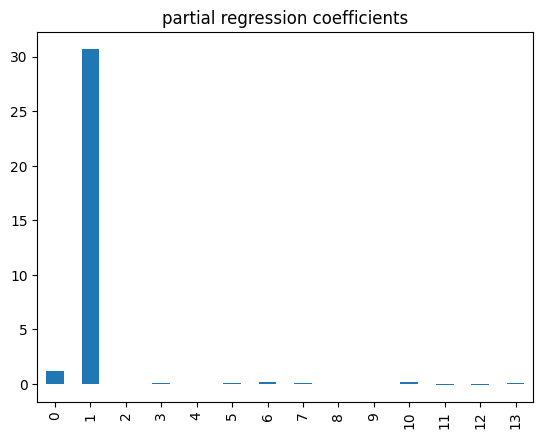

In [47]:
from sklearn.linear_model import LinearRegression

# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_val, model.predict(X2_val)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

## Decomposition

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [55]:
df[['sales']].describe()

,sales
count,3.000888e+06
mean,3.577757e+02
std,1.101998e+03
min,0.000000e+00
25%,0.000000e+00
50%,1.100000e+01
75%,1.958473e+02
max,1.247170e+05


In [56]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df['sales'], model='additive')
result_add.plot();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None